In [3]:
from __future__ import absolute_import, division, print_function

In [4]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [5]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [18]:
from subprocess import Popen, PIPE
from docx import Document
import pdfminer
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

from docx import Document
from docx.document import Document as _Document
from docx.oxml.text.paragraph import CT_P
from docx.oxml.table import CT_Tbl
from docx.table import _Cell, Table
from docx.text.paragraph import Paragraph

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
os.getcwd()

'D:\\D drive\\DataAnalytics_StudyMaterial\\IIMB-BDA\\ProjectZ\\Iteration2\\Case Writer-Applications\\Data'

In [119]:
os.chdir('D:\\D drive\\DataAnalytics_StudyMaterial\\IIMB-BDA\\ProjectZ\\Iteration2\\IIM')
#os.chdir('D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/Case Writer-Applications/Data')

## Convert pdf to text

In [11]:
#Function to convert pdf to text
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    fp.close()
    device.close()
    str1 = retstr.getvalue()
    retstr.close()
    return str1

## Read all docx blocks

In [12]:
#Read All Docx
def iter_block_items(parent):
    """
    Generate a reference to each paragraph and table child within *parent*,
    in document order. Each returned value is an instance of either Table or
    Paragraph. *parent* would most commonly be a reference to a main
    Document object, but also works for a _Cell object, which itself can
    contain paragraphs and tables.
    """
    if isinstance(parent, _Document):
        parent_elm = parent.element.body
        # print(parent_elm.xml)
    elif isinstance(parent, _Cell):
        parent_elm = parent._tc
    else:
        raise ValueError("something's not right")

    for child in parent_elm.iterchildren():
        if isinstance(child, CT_P):
            yield Paragraph(child, parent)
        elif isinstance(child, CT_Tbl):
            yield Table(child, parent)

## Convert Document to Text including PDF - Function

In [13]:
#Function to convert doc formats (like .doc, .docx, .odt) to text
def document_to_text(filename, file_path):
    if filename[-4:] == ".doc":
        cmd = ['C:/antiword/antiword', file_path] #use antiword command
        p = Popen(cmd, stdout=PIPE)
        stdout, stderr = p.communicate()
        return stdout.decode('ascii', 'ignore')
    elif filename[-5:] == ".docx":
        doc = Document(file_path)
        fullText = []
        para_ix=0
        tbl_ix=0
        for block in iter_block_items(doc):
            block_type=block.__class__.__name__
            if block_type=='Table':
                for row in doc.tables[tbl_ix].rows:
                    for cell in row.cells:
                        for paracell in cell.paragraphs:
                            fullText.append(paracell.text)
                tbl_ix+=1
            elif block_type=='Paragraph':
                fullText.append(doc.paragraphs[para_ix].text)
                para_ix+=1
        return '\n'.join(fullText)
    elif filename[-4:] == ".odt":
        cmd = ['odt2txt', file_path]
        p = Popen(cmd, stdout=PIPE)
        stdout, stderr = p.communicate()
        return stdout.decode('ascii', 'ignore')
    elif filename[-4:] == ".pdf":
        return convert_pdf_to_txt(file_path)

## Data Cleaner

In [20]:
import pandas as pd
import re

punctuations_list = [',', '?', ':', ';', '!', ')', '(', '\'','"','*','/','<','>','{','}','[',']']

def cleanStr(mystring):
    
    # Removing non-utf charachters with space
    mystring = re.sub(r'[^\x00-\x7F]+', ' ', str(mystring).lower())
    
    for punctuation in punctuations_list:            
        mystring = mystring.replace(punctuation, "".join(punctuation).join("  "))
        
    # Replacing 2 dots with one    
    mystring = mystring.replace("..", ". ")
    
    # Removing Multiple White spaces
    message = ' '.join(mystring.split())

    return message 

In [14]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Prepare Corpus

In [120]:
os.getcwd()

'D:\\D drive\\DataAnalytics_StudyMaterial\\IIMB-BDA\\ProjectZ\\Iteration2\\IIM'

In [121]:
resume_filenames = sorted(glob.glob("*.*"))

In [122]:
print("Found Resumes:")
resume_filenames

Found Resumes:


['AmitBats[6_0].doc',
 'BalakrishnaReddyS[4_6].docx',
 'Bharath-Paturi-CV.pdf',
 'CURRENT_022017_Santosh kumartoleti_Resume_f0fb3c53-c308-4f86-b335-b05ebd2cccc9_SantoshkumarToleti2_6.docx',
 'CURRENT_032017_BhaktiSubhash Naik_Resume_cf61cd93-ff05-4fc4-85ec-42301b5456f5_BhaktiSubhashNaik4_9.doc',
 'CURRENT_032017_Daljeet Singh DuggalDUGGAL_Resume_adb59f9d-a2e4-46b8-abdc-375b61107dc5_DaljeetSinghDuggal6_0.docx',
 'CURRENT_032017_DishantPatel_Resume_f88c74e3-8545-4156-a708-8d093885288e_DishantPatel6_0.docx',
 'CURRENT_032017_HIRALPARMAR_Resume_3e8d6f3d-2b01-4603-8a09-12a840772afc_hiral2_0.pdf',
 'CURRENT_032017_SHALINISHALINI K_Resume_e49f1c7b-d151-44b9-9afe-b774a6852495_SHALINIK2_7.docx',
 'CURRENT_032017_SandeeV S_Resume_2cd5e682-f1f0-4d95-9483-57a25f6965c0_SandeeVS4_3.doc',
 'CURRENT_032017_SnehlataKumari_Resume_2224bb2b-a3f9-4083-9d5d-5b0a158be3fc_SnehlataKumari2_8.doc',
 'CURRENT_032017_ravisankar_Resume_f243d558-3e41-4fa6-a67d-f324fb19b2d6_ravisankar4_5.doc',
 'CURRENT_032017_umasha

In [123]:
%%time
corpus_raw = u""
for resumes in resume_filenames:
    print("Reading '{0}'...".format(resumes))
    corpus_raw+=document_to_text(resumes,os.path.join('./',resumes))
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print() 
    
    

2017-07-01 19:11:59,998 : INFO : xref found: pos=b'419831'
2017-07-01 19:12:00,000 : INFO : read_xref_from: start=419831, token=/b'xref'
2017-07-01 19:12:00,003 : INFO : xref objects: {}
2017-07-01 19:12:00,007 : INFO : trailer: {'Size': 171, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:145>, 'ID': [b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad', b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad'], 'Prev': 416250, 'XRefStm': 415611}
2017-07-01 19:12:00,009 : INFO : read_xref_from: start=415611, token=170
2017-07-01 19:12:00,013 : INFO : xref stream: objid=(0, 170), fields=1,4,2
2017-07-01 19:12:00,015 : INFO : trailer: {'Type': /'XRef', 'Size': 170, 'W': [1, 4, 2], 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:145>, 'ID': [b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad', b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad'], 'Filter': /'FlateDecode', 'Length': 435}
2017-07-01 19:12:00,017 : INFO : read_xref_from: start=416250, token

Reading 'AmitBats[6_0].doc'...
Corpus is now 14433 characters long

Reading 'BalakrishnaReddyS[4_6].docx'...
Corpus is now 22915 characters long

Reading 'Bharath-Paturi-CV.pdf'...


2017-07-01 19:12:00,314 : INFO : trailer: {'Size': 171, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:145>, 'ID': [b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad', b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad']}
2017-07-01 19:12:00,321 : INFO : Pages: Kids=[<PDFObjRef:3>]
2017-07-01 19:12:00,338 : INFO : Page: {'Type': /'Page', 'Parent': <PDFObjRef:2>, 'Resources': {'ExtGState': {'GS5': <PDFObjRef:5>, 'GS6': <PDFObjRef:6>}, 'Font': {'F1': <PDFObjRef:7>, 'F2': <PDFObjRef:9>, 'F3': <PDFObjRef:11>, 'F4': <PDFObjRef:14>, 'F5': <PDFObjRef:16>, 'F6': <PDFObjRef:18>, 'F7': <PDFObjRef:20>, 'F8': <PDFObjRef:22>, 'F9': <PDFObjRef:27>, 'F10': <PDFObjRef:32>, 'F11': <PDFObjRef:37>}, 'ProcSet': [/'PDF', /'Text', /'ImageB', /'ImageC', /'ImageI']}, 'Annots': [<PDFObjRef:13>], 'MediaBox': [0, 0, 596.04, 842.04], 'Contents': <PDFObjRef:4>, 'Group': {'Type': /'Group', 'S': /'Transparency', 'CS': /'DeviceRGB'}, 'Tabs': /'S', 'StructParents': 0}
2017-07-01 19:12:00,345 : IN

Corpus is now 25137 characters long

Reading 'CURRENT_022017_Santosh kumartoleti_Resume_f0fb3c53-c308-4f86-b335-b05ebd2cccc9_SantoshkumarToleti2_6.docx'...
Corpus is now 31752 characters long

Reading 'CURRENT_032017_BhaktiSubhash Naik_Resume_cf61cd93-ff05-4fc4-85ec-42301b5456f5_BhaktiSubhashNaik4_9.doc'...
Corpus is now 35298 characters long

Reading 'CURRENT_032017_Daljeet Singh DuggalDUGGAL_Resume_adb59f9d-a2e4-46b8-abdc-375b61107dc5_DaljeetSinghDuggal6_0.docx'...


2017-07-01 19:12:01,878 : INFO : xref found: pos=b'30654'
2017-07-01 19:12:01,880 : INFO : read_xref_from: start=30654, token=/b'xref'
2017-07-01 19:12:01,882 : INFO : xref objects: {1: (None, 9, 0), 2: (None, 30549, 0), 3: (None, 167, 0), 4: (None, 262, 0), 5: (None, 609, 0), 6: (None, 30407, 0), 7: (None, 13844, 0), 8: (None, 299, 0), 9: (None, 350, 0), 10: (None, 401, 0), 11: (None, 453, 0), 12: (None, 505, 0), 13: (None, 557, 0), 14: (None, 19575, 0), 15: (None, 938, 0), 16: (None, 6315, 0), 17: (None, 730, 0), 18: (None, 918, 0), 19: (None, 8370, 0), 20: (None, 6336, 0), 21: (None, 6388, 0), 22: (None, 6440, 0), 23: (None, 6492, 0), 24: (None, 6544, 0), 25: (None, 8203, 0), 26: (None, 8065, 0), 27: (None, 6774, 0), 28: (None, 7184, 0), 29: (None, 7358, 0), 30: (None, 7654, 0), 31: (None, 7816, 0), 32: (None, 7947, 0), 33: (None, 6886, 0), 34: (None, 7034, 0), 35: (None, 7499, 0), 36: (None, 8266, 0), 37: (None, 8690, 0), 38: (None, 9864, 0), 39: (None, 8492, 0), 40: (None, 8670, 0

Corpus is now 42903 characters long

Reading 'CURRENT_032017_DishantPatel_Resume_f88c74e3-8545-4156-a708-8d093885288e_DishantPatel6_0.docx'...
Corpus is now 50708 characters long

Reading 'CURRENT_032017_HIRALPARMAR_Resume_3e8d6f3d-2b01-4603-8a09-12a840772afc_hiral2_0.pdf'...


2017-07-01 19:12:01,929 : INFO : trailer: {'Size': 56, 'Info': <PDFObjRef:1>, 'Root': <PDFObjRef:36>}
2017-07-01 19:12:01,934 : INFO : Pages: Kids=[<PDFObjRef:5>, <PDFObjRef:19>]
2017-07-01 19:12:01,939 : INFO : Page: {'Type': /'Page', 'Parent': <PDFObjRef:2>, 'Contents': <PDFObjRef:15>, 'Resources': <PDFObjRef:17>, 'Annots': <PDFObjRef:18>, 'MediaBox': [0, 0, 595, 842]}
2017-07-01 19:12:01,945 : INFO : Processing page: <PDFPage: Resources={'ColorSpace': {'PCSp': <PDFObjRef:4>, 'CSp': /'DeviceRGB', 'CSpg': /'DeviceGray'}, 'ExtGState': {'GSa': <PDFObjRef:3>}, 'Pattern': {}, 'Font': {'F6': <PDFObjRef:6>, 'F7': <PDFObjRef:7>, 'F14': <PDFObjRef:14>}, 'XObject': {}}, MediaBox=[0, 0, 595, 842]>
2017-07-01 19:12:01,947 : INFO : render_contents: resources={'ColorSpace': {'PCSp': <PDFObjRef:4>, 'CSp': /'DeviceRGB', 'CSpg': /'DeviceGray'}, 'ExtGState': {'GSa': <PDFObjRef:3>}, 'Pattern': {}, 'Font': {'F6': <PDFObjRef:6>, 'F7': <PDFObjRef:7>, 'F14': <PDFObjRef:14>}, 'XObject': {}}, streams=[<PDFSt

Corpus is now 53425 characters long

Reading 'CURRENT_032017_SHALINISHALINI K_Resume_e49f1c7b-d151-44b9-9afe-b774a6852495_SHALINIK2_7.docx'...
Corpus is now 58984 characters long

Reading 'CURRENT_032017_SandeeV S_Resume_2cd5e682-f1f0-4d95-9483-57a25f6965c0_SandeeVS4_3.doc'...
Corpus is now 77401 characters long

Reading 'CURRENT_032017_SnehlataKumari_Resume_2224bb2b-a3f9-4083-9d5d-5b0a158be3fc_SnehlataKumari2_8.doc'...
Corpus is now 81815 characters long

Reading 'CURRENT_032017_ravisankar_Resume_f243d558-3e41-4fa6-a67d-f324fb19b2d6_ravisankar4_5.doc'...
Corpus is now 92117 characters long

Reading 'CURRENT_032017_umashankar_Resume_77f65cee-4bce-4d83-9103-cc47c019eb96_umashankar11_0 (1).doc'...
Corpus is now 100333 characters long

Reading 'CURRENT_032017_yerramanenikoteswararao_Resume_560553c9-3c04-49c3-8702-a53b153ddb22_yerramanenikoteswararao5_2.docx'...
Corpus is now 108981 characters long

Reading 'CURRENT_042017_KARANVIRSINGH_Resume_24452b3d-e135-415d-b99e-a7c8a40d8891_KaranvirS

2017-07-01 19:12:04,047 : INFO : xref found: pos=b'127015'
2017-07-01 19:12:04,049 : INFO : read_xref_from: start=127015, token=/b'xref'
2017-07-01 19:12:04,051 : INFO : xref objects: {1: (None, 124760, 0), 2: (None, 19, 0), 3: (None, 4224, 0), 4: (None, 124903, 0), 5: (None, 4245, 0), 6: (None, 8567, 0), 7: (None, 126505, 0), 8: (None, 8588, 0), 9: (None, 10110, 0), 10: (None, 10131, 0), 11: (None, 10322, 0), 12: (None, 10614, 0), 13: (None, 10775, 0), 14: (None, 27091, 0), 15: (None, 27114, 0), 16: (None, 27329, 0), 17: (None, 27750, 0), 18: (None, 28042, 0), 19: (None, 56726, 0), 20: (None, 56749, 0), 21: (None, 56955, 0), 22: (None, 57521, 0), 23: (None, 57939, 0), 24: (None, 90808, 0), 25: (None, 90831, 0), 26: (None, 91032, 0), 27: (None, 91637, 0), 28: (None, 92086, 0), 29: (None, 122333, 0), 30: (None, 122356, 0), 31: (None, 122545, 0), 32: (None, 123592, 0), 33: (None, 124632, 0), 34: (None, 124705, 0), 35: (None, 125046, 0), 36: (None, 125102, 0), 37: (None, 125226, 0), 38: (

Corpus is now 177201 characters long

Reading 'CURRENT_052017_SaradhiPoluru_Resume_96f4e1db-a0b4-4d86-b78a-15737964766e_Saradhi3_3.docx'...
Corpus is now 185378 characters long

Reading 'CURRENT_052017_SaranSaran Kumar_Resume_3fa61230-f101-46b3-9cc4-b64192da89fd_SaranKumar4_0.doc'...
Corpus is now 195782 characters long

Reading 'CURRENT_052017_Shaikh ShadmaWarsi_Resume_af9ac017-9ce8-4e1b-b6c9-73d21feb820d_ShaikhShadmaWarsi3_3.docx'...
Corpus is now 205212 characters long

Reading 'CURRENT_052017_VIVEK KUMAR REDDYMUDUGANTI_Resume_f9d5afc7-1ddc-4702-9a6e-d6775cf9f68f_VivekReddy3_0.doc'...
Corpus is now 213923 characters long

Reading 'CURRENT_052017_YeshasMandya Devaraju_Resume_3fbd57d9-cd9e-4d75-bfad-38f1c526b427_YeshasMD4_3.docx'...
Corpus is now 219388 characters long

Reading 'CURRENT_052017_lakshmiprasad_Resume_1111a5b8-bac2-4e92-97f7-12ac4ea82ca4_lakshmiprasad4_0.doc'...
Corpus is now 227724 characters long

Reading 'CURRENT_052017_usharani_Resume_651d8412-2f0a-4908-a641-2c802d432

2017-07-01 19:12:05,994 : INFO : xref found: pos=b'62251'
2017-07-01 19:12:05,995 : INFO : read_xref_from: start=62251, token=/b'xref'
2017-07-01 19:12:05,998 : INFO : xref objects: {1: (None, 61708, 0), 2: (None, 61593, 0), 3: (None, 61900, 0), 4: (None, 59481, 0), 5: (None, 59108, 0), 6: (None, 52787, 0), 7: (None, 56617, 0), 8: (None, 15, 0), 9: (None, 56694, 0), 10: (None, 70, 0), 11: (None, 56832, 0), 12: (None, 126, 0), 13: (None, 56925, 0), 14: (None, 182, 0), 15: (None, 57024, 0), 16: (None, 238, 0), 17: (None, 57124, 0), 18: (None, 294, 0), 19: (None, 57243, 0), 20: (None, 350, 0), 21: (None, 57335, 0), 22: (None, 406, 0), 23: (None, 57460, 0), 24: (None, 462, 0), 25: (None, 52752, 0), 26: (None, 518, 0), 27: (None, 32602, 0), 28: (None, 31714, 0), 29: (None, 812, 0), 30: (None, 31981, 0), 31: (None, 33441, 0), 32: (None, 33173, 0), 33: (None, 34909, 0), 34: (None, 34647, 0), 35: (None, 36376, 0), 36: (None, 36105, 0), 37: (None, 37826, 0), 38: (None, 37577, 0), 39: (None, 390

Corpus is now 275851 characters long

Reading 'Ganesh[5_0].doc'...
Corpus is now 282684 characters long

Reading 'Java Resume 1.docx'...
Corpus is now 290048 characters long

Reading 'Java and Python Resume.pdf'...


2017-07-01 19:12:06,129 : INFO : trailer: {'Size': 138, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:3>, 'ID': [b"\xe5'\xfcNR*\xab_\x02~\x89j>\x06u'", b'<^VD\xa9%\xfem\x80\x1a(e\x952R(']}
2017-07-01 19:12:06,133 : INFO : Pages: Kids=[<PDFObjRef:6>]
2017-07-01 19:12:06,136 : INFO : Page: {'Type': /'Page', 'CropBox': [0, 0, 612, 792], 'MediaBox': [0, 0, 612, 792], 'Resources': {'ColorSpace': {'CS0': <PDFObjRef:25>}, 'Font': {'TT0': <PDFObjRef:27>, 'TT1': <PDFObjRef:31>, 'TT2': <PDFObjRef:33>, 'TT3': <PDFObjRef:35>, 'TT4': <PDFObjRef:37>}}, 'Contents': <PDFObjRef:39>, 'StructParents': 0, 'Tabs': /'S', 'Parent': <PDFObjRef:2>}
2017-07-01 19:12:06,141 : INFO : Processing page: <PDFPage: Resources={'ColorSpace': {'CS0': <PDFObjRef:25>}, 'Font': {'TT0': <PDFObjRef:27>, 'TT1': <PDFObjRef:31>, 'TT2': <PDFObjRef:33>, 'TT3': <PDFObjRef:35>, 'TT4': <PDFObjRef:37>}}, MediaBox=[0, 0, 612, 792]>
2017-07-01 19:12:06,142 : INFO : render_contents: resources={'ColorSpace': {'CS0': <PDFObjRef:25>}, 'Font': {

Corpus is now 293144 characters long

Reading 'John Paul.docx'...
Corpus is now 302226 characters long

Reading 'Mohit Patra.docx'...
Corpus is now 315105 characters long

Reading 'Munish-Kaushik - 2017.docx'...
Corpus is now 324871 characters long

Reading 'NagendraSwami[2_0].docx'...
Corpus is now 342237 characters long

Reading 'New York.docx'...
Corpus is now 353598 characters long

Reading 'PrasannaKumar.docx'...
Corpus is now 370360 characters long

Reading 'Raj Malhotra.docx'...
Corpus is now 381730 characters long

Reading 'RajashekharaiahM[4_0].docx'...


2017-07-01 19:12:07,975 : INFO : xref found: pos=b'134706'
2017-07-01 19:12:07,977 : INFO : read_xref_from: start=134706, token=/b'xref'
2017-07-01 19:12:07,980 : INFO : xref objects: {1: (None, 134181, 0), 2: (None, 134124, 0), 3: (None, 134355, 0), 4: (None, 132013, 0), 5: (None, 131640, 0), 6: (None, 125007, 0), 7: (None, 124940, 0), 8: (None, 15, 0), 9: (None, 124973, 0), 10: (None, 308, 0), 11: (None, 7735, 0), 12: (None, 7407, 0), 13: (None, 7231, 0), 14: (None, 2961, 0), 15: (None, 6951, 0), 16: (None, 3036, 0), 17: (None, 3123, 0), 18: (None, 7432, 0), 19: (None, 39666, 0), 20: (None, 38778, 0), 21: (None, 7876, 0), 22: (None, 39045, 0), 23: (None, 67088, 0), 24: (None, 66264, 0), 25: (None, 40237, 0), 26: (None, 66537, 0), 27: (None, 91768, 0), 28: (None, 91034, 0), 29: (None, 67574, 0), 30: (None, 91315, 0), 31: (None, 113946, 0), 32: (None, 113256, 0), 33: (None, 92210, 0), 34: (None, 113534, 0), 35: (None, 114604, 0), 36: (None, 114362, 0), 37: (None, 115921, 0), 38: (None,

Corpus is now 392418 characters long

Reading 'Rajesh[6_0].docx'...
Corpus is now 403673 characters long

Reading 'Resume Masters.pdf'...


2017-07-01 19:12:08,142 : INFO : trailer: {'Size': 161, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:3>, 'ID': [b'X{:o\xe17\xf8q\xbcD\xcaQAA\xe5z', b'\x0c\x12\xcb+\xa4~\xca,uY\x8el\xa6l#r']}
2017-07-01 19:12:08,146 : INFO : Pages: Kids=[<PDFObjRef:6>]
2017-07-01 19:12:08,149 : INFO : Page: {'Type': /'Page', 'CropBox': [0, 0, 612, 792], 'MediaBox': [0, 0, 612, 792], 'Resources': {'ColorSpace': {'CS0': <PDFObjRef:7>, 'CS1': <PDFObjRef:9>}, 'Font': {'C2_0': <PDFObjRef:11>, 'TT0': <PDFObjRef:19>, 'TT1': <PDFObjRef:23>, 'TT2': <PDFObjRef:27>, 'TT3': <PDFObjRef:31>, 'TT4': <PDFObjRef:35>}}, 'Annots': [<PDFObjRef:37>], 'Contents': <PDFObjRef:44>, 'StructParents': 1, 'Tabs': /'S', 'Parent': <PDFObjRef:2>}
2017-07-01 19:12:08,153 : INFO : Processing page: <PDFPage: Resources={'ColorSpace': {'CS0': <PDFObjRef:7>, 'CS1': <PDFObjRef:9>}, 'Font': {'C2_0': <PDFObjRef:11>, 'TT0': <PDFObjRef:19>, 'TT1': <PDFObjRef:23>, 'TT2': <PDFObjRef:27>, 'TT3': <PDFObjRef:31>, 'TT4': <PDFObjRef:35>}}, MediaBox=[0, 0,

Corpus is now 405958 characters long

Reading 'RohitKhanna.docx'...
Corpus is now 407946 characters long

Reading 'SQL Server Visual Basic Resume 1.docx'...
Corpus is now 421962 characters long

Reading 'SWETA[2_11].pdf'...


2017-07-01 19:12:09,189 : INFO : trailer: {'Size': 337, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:53>, 'ID': [b'\xf8\xce\x13\xb2?@hH\x8a\xf0\x1c\x85\xe4\xab\xa9,', b'\xf8\xce\x13\xb2?@hH\x8a\xf0\x1c\x85\xe4\xab\xa9,']}
2017-07-01 19:12:09,193 : INFO : Pages: Kids=[<PDFObjRef:3>, <PDFObjRef:13>, <PDFObjRef:30>, <PDFObjRef:39>, <PDFObjRef:51>]
2017-07-01 19:12:09,196 : INFO : Page: {'Type': /'Page', 'Parent': <PDFObjRef:2>, 'Resources': {'Font': {'F1': <PDFObjRef:5>, 'F2': <PDFObjRef:9>, 'F3': <PDFObjRef:11>}, 'ExtGState': {'GS7': <PDFObjRef:7>, 'GS8': <PDFObjRef:8>}, 'ProcSet': [/'PDF', /'Text', /'ImageB', /'ImageC', /'ImageI']}, 'MediaBox': [0, 0, 612, 792], 'Contents': <PDFObjRef:4>, 'Group': {'Type': /'Group', 'S': /'Transparency', 'CS': /'DeviceRGB'}, 'Tabs': /'S', 'StructParents': 0}
2017-07-01 19:12:09,199 : INFO : Processing page: <PDFPage: Resources={'Font': {'F1': <PDFObjRef:5>, 'F2': <PDFObjRef:9>, 'F3': <PDFObjRef:11>}, 'ExtGState': {'GS7': <PDFObjRef:7>, 'GS8': <PDFObjRef:8>

Corpus is now 426484 characters long

Reading 'Sahib Singh.docx'...
Corpus is now 442423 characters long

Reading 'Senior Java Dev Resume 2.docx'...
Corpus is now 457946 characters long

Reading 'Shwetarathore[5_0].docx'...
Corpus is now 470737 characters long

Reading 'Sumit Shastry.docx'...


2017-07-01 19:12:11,088 : INFO : xref found: pos=b'161167'
2017-07-01 19:12:11,090 : INFO : read_xref_from: start=161167, token=/b'xref'
2017-07-01 19:12:11,092 : INFO : xref objects: {}
2017-07-01 19:12:11,094 : INFO : trailer: {'Size': 430, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:49>, 'ID': [b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$', b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$'], 'Prev': 152407, 'XRefStm': 151254}
2017-07-01 19:12:11,096 : INFO : read_xref_from: start=151254, token=429
2017-07-01 19:12:11,099 : INFO : xref stream: objid=(0, 429), fields=1,4,2
2017-07-01 19:12:11,101 : INFO : trailer: {'Type': /'XRef', 'Size': 429, 'W': [1, 4, 2], 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:49>, 'ID': [b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$', b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$'], 'Filter': /'FlateDecode', 'Length': 950}
2017-07-01 19:12:11,102 : INFO : read_xref_from: start=152407, token=/b'xref'
2017-07-01 19:12:11,112 : INFO : xref objects: {1: (

Corpus is now 483196 characters long

Reading 'Sunil Kumar Petluri1.pdf'...


2017-07-01 19:12:11,448 : INFO : trailer: {'Size': 430, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:49>, 'ID': [b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$', b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$']}
2017-07-01 19:12:11,453 : INFO : Pages: Kids=[<PDFObjRef:3>, <PDFObjRef:27>, <PDFObjRef:43>, <PDFObjRef:45>, <PDFObjRef:47>]
2017-07-01 19:12:11,457 : INFO : Page: {'Type': /'Page', 'Parent': <PDFObjRef:2>, 'Resources': {'Font': {'F1': <PDFObjRef:5>, 'F2': <PDFObjRef:9>, 'F3': <PDFObjRef:11>, 'F4': <PDFObjRef:15>, 'F5': <PDFObjRef:20>, 'F6': <PDFObjRef:22>}, 'ExtGState': {'GS7': <PDFObjRef:7>, 'GS8': <PDFObjRef:8>}, 'ProcSet': [/'PDF', /'Text', /'ImageB', /'ImageC', /'ImageI']}, 'Annots': [<PDFObjRef:13>, <PDFObjRef:14>], 'MediaBox': [0, 0, 612, 792], 'Contents': <PDFObjRef:4>, 'Group': {'Type': /'Group', 'S': /'Transparency', 'CS': /'DeviceRGB'}, 'Tabs': /'S', 'StructParents': 0}
2017-07-01 19:12:11,460 : INFO : Processing page: <PDFPage: Resources={'Font': {'F1': <PDFObjRef:

Corpus is now 496363 characters long

Reading 'Teradata Resume 2.docx'...
Corpus is now 509867 characters long

Reading 'Terdata Resume 1.docx'...
Corpus is now 514897 characters long

Reading 'VNPoornimaDeviS[4_7].docx'...
Corpus is now 521889 characters long

Reading 'Venkatesh[4_1].doc'...
Corpus is now 527979 characters long

Reading 'kishorekumar.docx'...
Corpus is now 531399 characters long

Reading 'punitSingh.docx'...
Corpus is now 534980 characters long

Wall time: 14.2 s


In [124]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [125]:
raw_sentences = tokenizer.tokenize(corpus_raw)

## Cleanup - preprocessing

In [164]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
punctuations_list = [',', '?', ':', ';', '!', ')', '(', '\'','"','*','/','<','>','{','}','[',']']

In [165]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    for punctuation in punctuations_list:            
        raw = raw.replace(punctuation, " ")
    clean1 = re.sub("\|"," ", raw)
    clean2 = re.sub("\r\n"," ",clean1)
    clean3 = re.sub("\t", " ", clean2)
    clean4 = re.sub("\n", " ", clean3)
    clean5 = cleanStr(clean4)
    clean6 = clean5.lower().split()
    words=[w for w in clean6 if w not in stop_words]
    return words



In [166]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [167]:
print(raw_sentences[1])
print(sentence_to_wordlist(raw_sentences[1]))

|
|Hands on experience in Java and J2EE (JDBC, Servlet, JSP).
['hands', 'experience', 'java', 'j2ee', 'jdbc', 'servlet', 'jsp', '.']


In [168]:
token_count = sum([len(sentence) for sentence in sentences])
print("The resumes corpus contains {0:,} tokens".format(token_count))

The resumes corpus contains 54,434 tokens


In [169]:
multiprocessing.cpu_count()

4

## Train Word2Vec

In [211]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 500
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 4

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

token_count = sum([len(sentence) for sentence in sentences])

In [212]:
res2vec=w2v.Word2Vec(sg=0,seed=seed,workers=num_workers,size=num_features,min_count=min_word_count,window=context_size,sample=downsampling)

In [213]:
%%time
res2vec.build_vocab(sentences)

2017-07-02 02:13:14,119 : INFO : collecting all words and their counts
2017-07-02 02:13:14,122 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-07-02 02:13:14,148 : INFO : collected 8752 word types from a corpus of 54434 raw words and 4070 sentences
2017-07-02 02:13:14,151 : INFO : Loading a fresh vocabulary
2017-07-02 02:13:14,177 : INFO : min_count=3 retains 3028 unique words (34% of original 8752, drops 5724)
2017-07-02 02:13:14,179 : INFO : min_count=3 leaves 47308 word corpus (86% of original 54434, drops 7126)
2017-07-02 02:13:14,207 : INFO : deleting the raw counts dictionary of 8752 items
2017-07-02 02:13:14,209 : INFO : sample=0.001 downsamples 45 most-common words
2017-07-02 02:13:14,211 : INFO : downsampling leaves estimated 43357 word corpus (91.6% of prior 47308)
2017-07-02 02:13:14,213 : INFO : estimated required memory for 3028 words and 500 dimensions: 13626000 bytes
2017-07-02 02:13:14,237 : INFO : resetting layer weights


Wall time: 242 ms


In [214]:
print("Word2Vec vocabulary length:", len(res2vec.wv.vocab))

Word2Vec vocabulary length: 3028


## Start Training

In [215]:
%%time
res2vec.train(sentences,total_examples = token_count,epochs = res2vec.iter )

2017-07-02 02:13:30,548 : INFO : training model with 4 workers on 3028 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=4
2017-07-02 02:13:31,247 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-07-02 02:13:31,252 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-07-02 02:13:31,276 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-07-02 02:13:31,284 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-07-02 02:13:31,286 : INFO : training on 272170 raw words (216808 effective words) took 0.7s, 303823 effective words/s
2017-07-02 02:13:31,288 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2017-07-02 02:13:31,290 : WARNING : supplied example count (20350) did not equal expected count (272170)


Wall time: 742 ms


216808

In [216]:
res2vec.save(os.path.join('../res2vecModITDomain4CBOW.w2v'))

2017-07-02 02:13:55,842 : INFO : saving Word2Vec object under ../res2vecModITDomain4CBOW.w2v, separately None
2017-07-02 02:13:55,845 : INFO : not storing attribute syn0norm
2017-07-02 02:13:55,847 : INFO : not storing attribute cum_table
2017-07-02 02:13:56,058 : INFO : saved ../res2vecModITDomain4CBOW.w2v


In [217]:
res2vec = w2v.Word2Vec.load(os.path.join('../res2vecModITDomain4CBOW.w2v'))

2017-07-02 02:14:00,085 : INFO : loading Word2Vec object from ../res2vecModITDomain4CBOW.w2v
2017-07-02 02:14:00,273 : INFO : loading wv recursively from ../res2vecModITDomain4CBOW.w2v.wv.* with mmap=None
2017-07-02 02:14:00,274 : INFO : setting ignored attribute syn0norm to None
2017-07-02 02:14:00,276 : INFO : setting ignored attribute cum_table to None
2017-07-02 02:14:00,277 : INFO : loaded ../res2vecModITDomain4CBOW.w2v


## Test Model

In [112]:
%%time
os.chdir('D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/Case Writer-Applications/TestData')
resume_filenames_test = sorted(glob.glob("*.*"))

corpus_raw_test = u""
for resumes in resume_filenames_test:
    print("Reading '{0}'...".format(resumes))
    corpus_raw_test+=document_to_text(resumes,os.path.join('./',resumes))
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print() 
    

2017-07-01 18:59:39,886 : INFO : xref found: pos=b'116'
2017-07-01 18:59:39,888 : INFO : read_xref_from: start=116, token=162
2017-07-01 18:59:39,893 : INFO : xref stream: objid=(146, 31), fields=1,2,1
2017-07-01 18:59:39,895 : INFO : trailer: {'DecodeParms': {'Columns': 4, 'Predictor': 12}, 'Filter': /'FlateDecode', 'ID': [b'#y\x94~<\x14\xddE\x8a\xf9>{\xdd\t\xce,', b'\x8b\xf8\x00\x80\x9f\xe05M\x9e\x00\xdc*G\xbf\x8c\xf6'], 'Index': [146, 31], 'Info': <PDFObjRef:145>, 'Length': 82, 'Prev': 26967, 'Root': <PDFObjRef:147>, 'Size': 177, 'Type': /'XRef', 'W': [1, 2, 1]}
2017-07-01 18:59:39,897 : INFO : read_xref_from: start=26967, token=10
2017-07-01 18:59:39,902 : INFO : xref stream: objid=(0, 146), fields=1,2,1
2017-07-01 18:59:39,904 : INFO : trailer: {'DecodeParms': {'Columns': 4, 'Predictor': 12}, 'Filter': /'FlateDecode', 'ID': [b'#y\x94~<\x14\xddE\x8a\xf9>{\xdd\t\xce,', b'\x8b\xf8\x00\x80\x9f\xe05M\x9e\x00\xdc*G\xbf\x8c\xf6'], 'Info': <PDFObjRef:145>, 'Length': 74, 'Root': <PDFObjRef

Reading 'AnitaGanguli_363321_-15_-_1.docx'...
Corpus is now 686294 characters long

Reading 'AnumehaVerma_362785_-07_00-_1.pdf'...


2017-07-01 18:59:40,113 : INFO : Pages: Kids=[<PDFObjRef:148>, <PDFObjRef:1>]
2017-07-01 18:59:40,125 : INFO : Page: {'Contents': [<PDFObjRef:150>, <PDFObjRef:151>, <PDFObjRef:152>, <PDFObjRef:153>, <PDFObjRef:154>, <PDFObjRef:155>, <PDFObjRef:156>, <PDFObjRef:158>], 'CropBox': [0.0, 0.0, 595.32, 841.92], 'Group': <PDFObjRef:175>, 'MediaBox': [0.0, 0.0, 595.32, 841.92], 'Parent': <PDFObjRef:144>, 'Resources': {'ColorSpace': {'CS0': <PDFObjRef:163>, 'CS1': <PDFObjRef:164>, 'CS2': <PDFObjRef:163>}, 'ExtGState': {'GS0': <PDFObjRef:165>}, 'Font': {'TT0': <PDFObjRef:167>, 'TT1': <PDFObjRef:169>, 'TT2': <PDFObjRef:171>, 'TT3': <PDFObjRef:173>}, 'XObject': {'Im0': <PDFObjRef:157>, 'Im1': <PDFObjRef:157>, 'Im10': <PDFObjRef:157>, 'Im11': <PDFObjRef:157>, 'Im12': <PDFObjRef:157>, 'Im13': <PDFObjRef:157>, 'Im14': <PDFObjRef:157>, 'Im15': <PDFObjRef:157>, 'Im16': <PDFObjRef:157>, 'Im17': <PDFObjRef:157>, 'Im18': <PDFObjRef:157>, 'Im19': <PDFObjRef:157>, 'Im2': <PDFObjRef:157>, 'Im3': <PDFObjRef:1

Corpus is now 686294 characters long

Reading 'KellyKislaya_359993_-06_00-_1.doc'...
Corpus is now 686294 characters long

Reading 'MunmunMitra_357457_-11_00-_1.doc'...
Corpus is now 686294 characters long

Reading 'Rajiv  B _JOB010014HR_Uploads_.pdf'...


2017-07-01 18:59:41,484 : INFO : get_font: create: objid=43, spec={'BaseFont': /'FBCDEE+Symbol', 'DW': 1000, 'DescendantFonts': [<PDFObjRef:42>], 'Encoding': /'Identity-H', 'Name': /'F11', 'Subtype': /'Type0', 'ToUnicode': <PDFObjRef:23>, 'Type': /'Font'}
2017-07-01 18:59:41,490 : INFO : get_font: create: objid=None, spec={'BaseFont': /'FBCDEE+Symbol', 'CIDSystemInfo': {'Ordering': b'Identity', 'Registry': b'Adobe', 'Supplement': 0}, 'CIDToGIDMap': /'Identity', 'FontDescriptor': <PDFObjRef:41>, 'Subtype': /'CIDFontType2', 'Type': /'Font', 'W': [120, [460]], 'Encoding': /'Identity-H', 'ToUnicode': <PDFStream(23): raw=230, {'Filter': [/'FlateDecode'], 'Length': 228}>}
2017-07-01 18:59:41,496 : INFO : get_font: create: objid=46, spec={'BaseFont': /'GBCDEE+Arial', 'DW': 1000, 'DescendantFonts': [<PDFObjRef:45>], 'Encoding': /'Identity-H', 'Name': /'F12', 'Subtype': /'Type0', 'ToUnicode': <PDFObjRef:24>, 'Type': /'Font'}
2017-07-01 18:59:41,500 : INFO : get_font: create: objid=None, spec={'

Corpus is now 686294 characters long

Reading 'VidyaGautham_362551_-09_00-_1.doc'...
Corpus is now 686294 characters long

Wall time: 2.91 s


In [115]:
raw_sentences_test = tokenizer.tokenize(corpus_raw_test)

#sentence where each word is tokenized
sentences_test = []
for raw_sentence in raw_sentences_test:
    if len(raw_sentence) > 0:
        sentences_test.append(sentence_to_wordlist(raw_sentence))

In [228]:
#res2vec.accuracy(corpus_raw_test)

## Explore Trained Model

In [218]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [219]:
all_word_vectors_matrix = res2vec.wv.syn0

In [220]:
%%time
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

Wall time: 1min 9s


## Plot the model

In [221]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[res2vec.wv.vocab[word].index])
            for word in res2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [222]:
points.head(10)

,word,x,y
0,professional,-9.550831,0.379533
1,summary,-9.498754,-0.050809
2,6,-8.265814,-12.330054
3,years,-7.948086,-6.544656
4,experience,-7.877292,-6.779753
5,software,-4.679388,14.952334
6,developer,-4.905546,13.566231
7,industry.,-6.390371,1.037626
8,hands,13.617215,5.877726
9,java,-3.136567,15.849635


In [223]:
sns.set_context("poster")

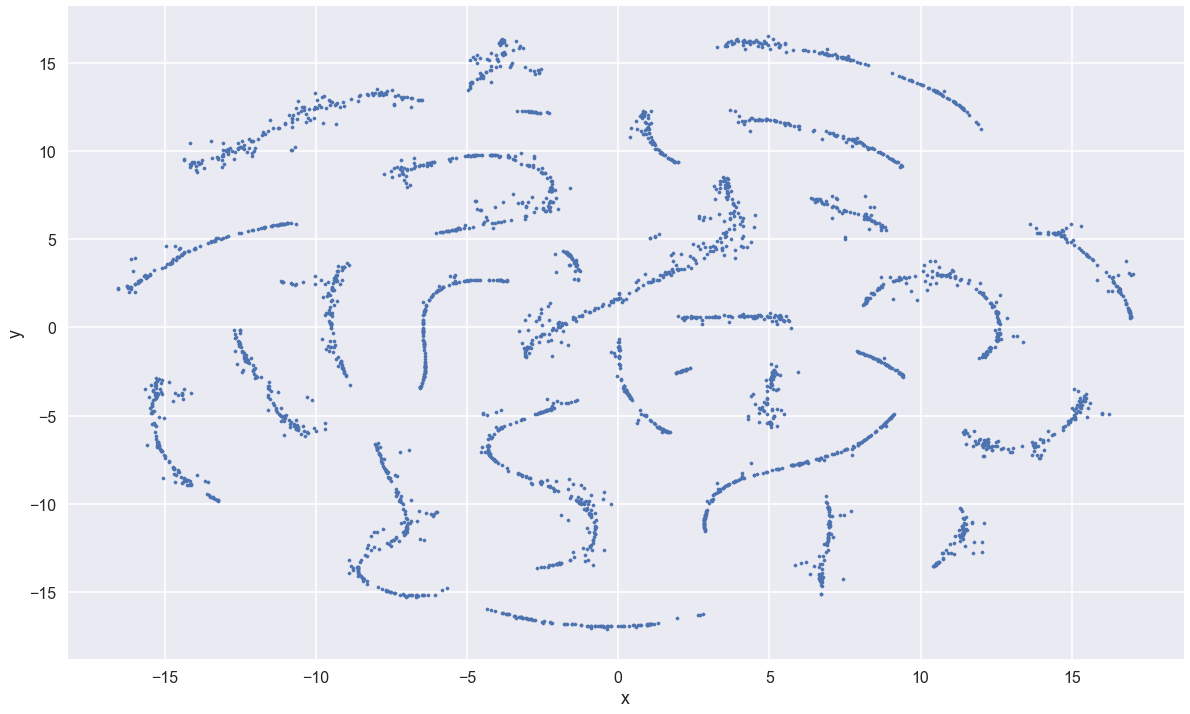

In [224]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [225]:
def plot_region(x_bounds, y_bounds):
    slc = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slc.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slc.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

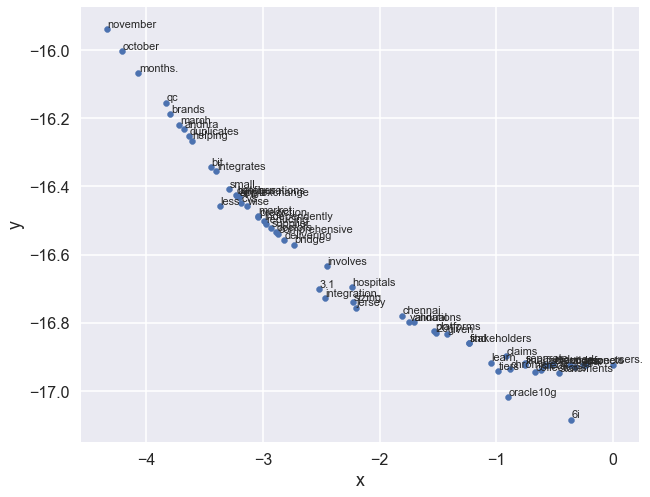

In [227]:
plot_region(x_bounds=(-5, 0), y_bounds=(-20, -15))

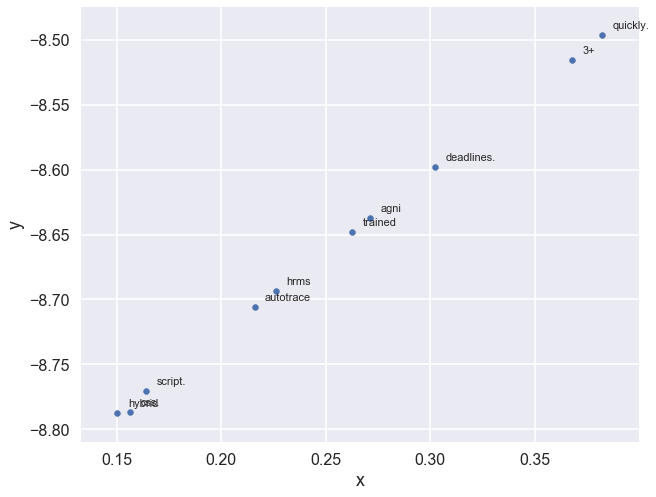

In [210]:
plot_region(x_bounds=(0,0.4), y_bounds=(-8.8,-8.4))